In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
from pathlib import Path
ROOT_DIR = os.path.abspath(os.path.join(Path().absolute(), os.pardir))
sys.path.insert(1, ROOT_DIR)

In [5]:
from time import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
from frequency_response import FrequencyResponse

In [6]:
def fft_time(x):
    start = time()
    X = scipy.fftpack.fft(x)
    #X = np.fft.fft(x)
    return time() - start

In [13]:
start = 2
end = 10000
y = np.random.random(end-start)
n = np.arange(start, end)
fast_n = [2]
while fast_n[-1] < end:
    fast_n.append(scipy.fftpack.next_fast_len(fast_n[-1]+1))
fast_n = np.array(fast_n)

t = []
fast_t = []
for i in n:
    d = fft_time(y[:i])
    t.append(d)
    if i in fast_n:
        fast_t.append(d)
t = np.array(t)
fast_t = np.array(fast_t)
fast_n = fast_n[:-1]

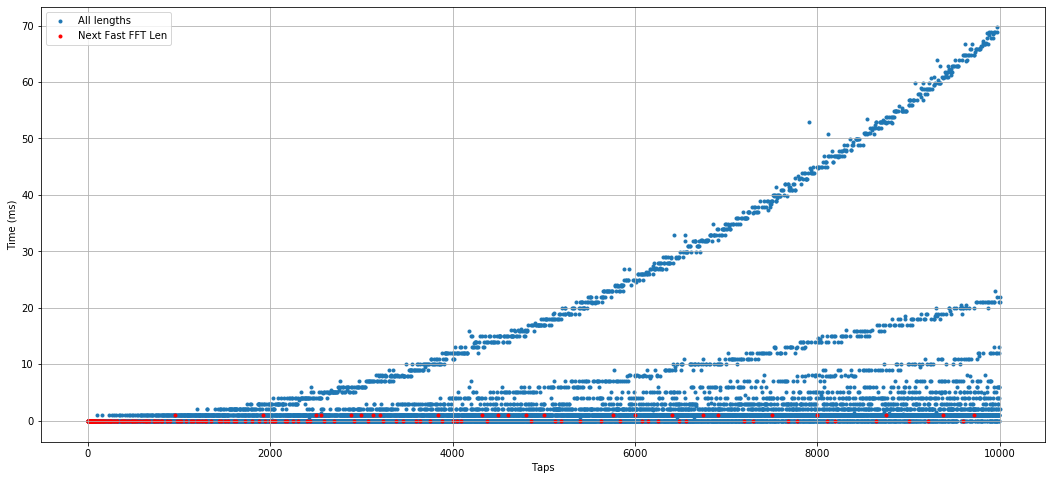

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax.scatter(n, t*1000, marker='.', label='All lengths')
ax.scatter(fast_n, fast_t*1000, marker='.', color='red', label='Next Fast FFT Len')
ax.grid(True)
ax.set_xlabel('Taps')
ax.set_ylabel('Time (ms)')
ax.legend()
plt.show()

In [118]:
start = 2
end = 48000 * 7
y = np.random.random(end-start)
fast_n = [2]
fast_t = []
while fast_n[-1] < end:
    fast_t.append(fft_time(y[:fast_n[-1]]))
    fast_n.append(scipy.fftpack.next_fast_len(fast_n[-1]+1))
fast_n = np.array(fast_n[:-1])
fast_t = np.array(fast_t)

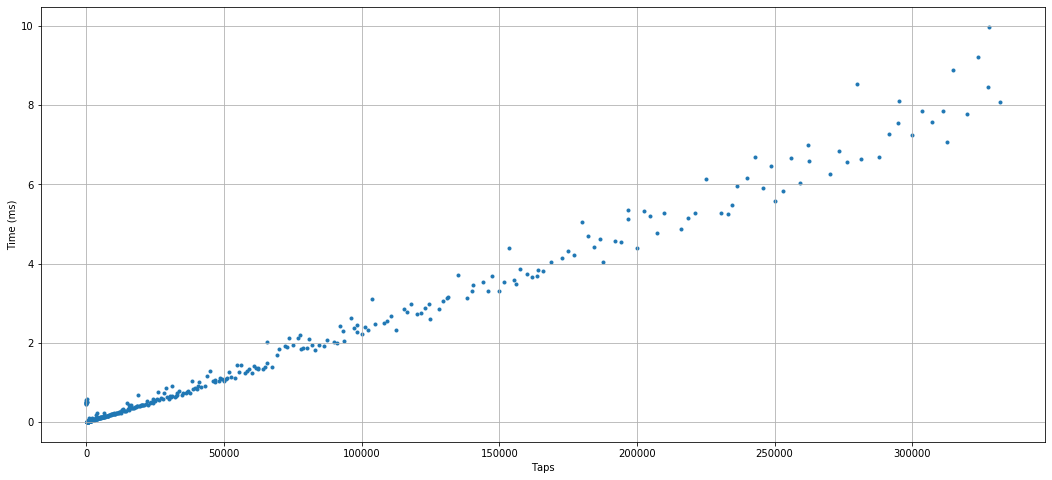

In [119]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax.scatter(fast_n, fast_t*1000, marker='.')
ax.grid(True)
ax.set_xlabel('Taps')
ax.set_ylabel('Time (ms)')
plt.show()

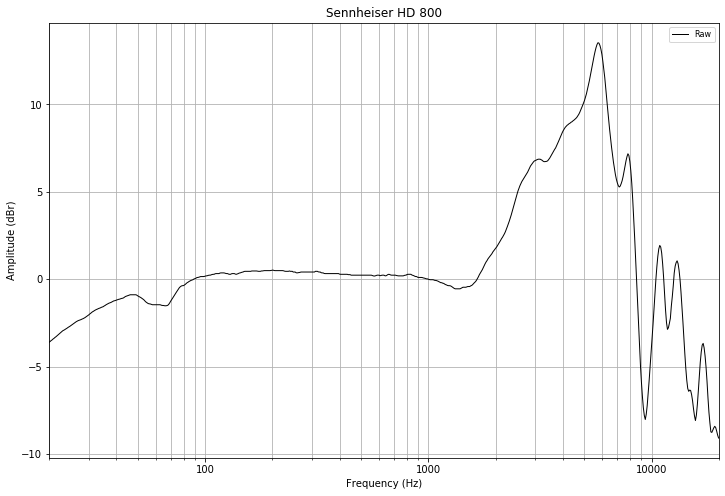

In [145]:
fr = FrequencyResponse.read_from_csv(os.path.join(ROOT_DIR, 'results', 'oratory1990', 'harman_over-ear_2018', 'Sennheiser HD 800', 'Sennheiser HD 800.csv'))
fr.plot_graph(show=False)
plt.show()

In [139]:
from scipy.fftpack import fft

def magnitude_response(x, fs):
    """Calculates frequency magnitude response
    Args:
        x: Audio data
        fs: Sampling rate
    Returns:
        - **f:** Frequencies
        - **X:** Magnitudes
    """
    _x = x
    nfft = len(_x)
    df = fs / nfft
    f = np.arange(0, fs - df, df)
    X = fft(_x)
    X_mag = 20 * np.log10(np.abs(X))
    fr = FrequencyResponse(name='fr', frequency=f[0:int(np.ceil(nfft/2))], raw=X_mag[0:int(np.ceil(nfft/2))])
    #fr.interpolate()
    return fr

In [160]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.fftpack import next_fast_len
from scipy.signal import savgol_filter, find_peaks, minimum_phase, firwin2


def minimum_phase_impulse_response(f, r, fs=48000, f_res=10, normalize=True, epsilon=0.01):
    """Generates minimum phase impulse response

    Inspired by:
    https://sourceforge.net/p/equalizerapo/code/HEAD/tree/tags/1.2/filters/GraphicEQFilter.cpp#l45

    Args:
        fs: Sampling frequency in Hz
        f_res: Frequency resolution as sampling interval. 20 would result in sampling at 0 Hz, 20 Hz, 40 Hz, ...
        normalize: Normalize gain to -0.5 dB

    Returns:
        Minimum phase impulse response
    """
    # Double frequency resolution because it will be halved when converting linear phase IR to minimum phase
    f_res /= 2
    # Interpolate to even sample interval
    fr = FrequencyResponse(name='fr_data', frequency=f.copy(), raw=r.copy())
    # Save gain at lowest available frequency
    f_min = np.max([fr.frequency[0], f_res])
    interpolator = InterpolatedUnivariateSpline(np.log10(fr.frequency), fr.raw, k=1)
    gain_f_min = interpolator(np.log10(f_min))
    # Filter length, optimized for FFT speed
    n = round(fs // 2 / f_res)
    n = next_fast_len(n)
    f = np.linspace(0.0, fs // 2, n)
    # Run interpolation
    fr.interpolate(f, pol_order=1)
    # Set gain for all frequencies below original minimum frequency to match gain at the original minimum frequency
    fr.raw[fr.frequency <= f_min] = gain_f_min
    if normalize:
        # Reduce by max gain to avoid clipping with 1 dB of headroom
        fr.raw -= np.max(fr.raw)
        fr.raw -= 0.5
    # Minimum phase transformation by scipy's homomorphic method halves dB gain
    fr.raw *= 2
    # Convert amplitude to linear scale
    fr.raw = 10**(fr.raw / 20)
    # Zero gain at Nyquist frequency
    fr.raw[-1] = 0.0
    # Calculate response
    ir = firwin2(len(fr.frequency)*2, fr.frequency, fr.raw, fs=fs)
    # Convert to minimum phase
    n_fft = 2 ** int(np.ceil(np.log2(2 * (len(ir) - 1) / epsilon)))
    ir = minimum_phase(ir, n_fft=n_fft)
    return ir

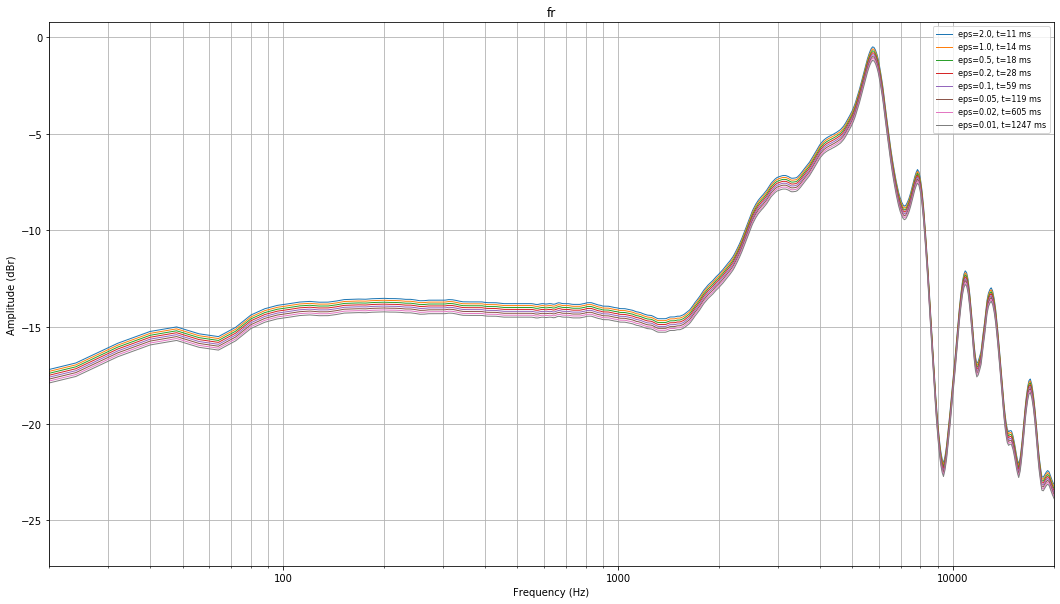

In [161]:
fs = 48000
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
for i, epsilon in enumerate([2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]):
    t = time()
    fir = minimum_phase_impulse_response(fr.frequency, fr.raw, fs=fs, f_res=8, epsilon=epsilon)
    fir_fr = magnitude_response(fir, fs)
    fir_fr.raw -= i*0.1
    fir_fr.plot_graph(fig=fig, ax=ax, show=False, raw_plot_kwargs={'label': f'eps={epsilon}, t={(time()-t)*1000:.0f} ms', 'color': f'C{i}'})
plt.show()

In [26]:
import re
header_pattern = r'frequency(,(raw|smoothed|error|error_smoothed|equalization|parametric_eq|equalized_raw|equalized_smoothed|target))+'
float_pattern = r'-?\d+\.?\d+'
data_2_pattern = r'{fl}[ ,;:\t]+{fl}?'.format(fl=float_pattern)
data_n_pattern = r'{fl}([ ,;:\t]+{fl})+?'.format(fl=float_pattern)
autoeq_pattern = r'^{header}(\n{data})+\n*$'.format(header=header_pattern, data=data_n_pattern)

In [44]:
with open(os.path.join(ROOT_DIR, 'results', 'oratory1990', 'harman_over-ear_2018', 'Sennheiser HD 800', 'Sennheiser HD 800.csv'), 'r', encoding='utf-8') as fh:
    s = fh.read()
    lines = s.split('\n')
header = lines[0]
print(header)
print(re.match(header_pattern, 'frequency,raw,error,smoothed,target'))
print(re.match(data_n_pattern, lines[1]))
print(re.match(rf'^{header_pattern}\n{data_n_pattern}.*', s))
print(s[34:36])

frequency,raw,error,smoothed,error_smoothed,equalization,parametric_eq,fixed_band_eq,equalized_raw,equalized_smoothed,target
<_sre.SRE_Match object; span=(0, 35), match='frequency,raw,error,smoothed,target'>
<_sre.SRE_Match object; span=(0, 11), match='20.00,-3.60'>
None
_s
